This notebook outlines the transect defintions I plan to use for transport calulations in GLORYS12

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
glorys_path='/data/cmems/my.cmems-du.eu/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083-climatology_P1M-m/'
statics = '/data/cmems/my.cmems-du.eu/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083-static/GLO-MFC_001_030_coordinates.nc'
mask = '/data/cmems/my.cmems-du.eu/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083-static/GLO-MFC_001_030_mask_bathy.nc'

In [3]:
lon_min=-60
lat_min=45
lon_max=-40
lat_max=55

In [4]:
# etopo file
ef = '/home/soontiensn/data/ocn-nav/ETOPO1_Bed_g_gmt4.grd'
etopo = xr.open_dataset(ef)
esel = etopo.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))

In [5]:
def plot_bathymetry(ax, etopo):
    lons = etopo.x.values
    lats = etopo.y.values
    lons, lats = np.meshgrid(lons,lats)
    bathy = etopo.z.values
    levels = [-1000,-500, -200,0]
    CS = ax.contour(lons,lats,bathy,levels, linestyles='solid', linewidths=1,colors='k')

In [6]:
d = xr.open_mfdataset('{}/*'.format(glorys_path))
dsel = d.sel(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))

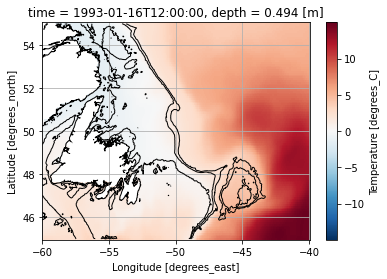

In [7]:
fig,ax = plt.subplots(1,1)
dsel.thetao.isel(time=0,depth=0).plot(ax=ax)
plot_bathymetry(ax,esel)
ax.grid()

# Strait of Belle Isle
Plot the depth averaged currents to identify a transect

In [8]:
outname = 'BelleIsle-depavclim.nc'
lon_min=-58
lat_min=50
lon_max=-55
lat_max=52
if not os.path.exists(outname):


    dstatic = xr.open_dataset(statics).sel(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))
    dmask = xr.open_dataset(mask).sel(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))
    dsel = d.sel(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))

    udepav = (dsel.uo * dstatic.e3t * dmask.mask).sum(dim='depth')/( dstatic.e3t * dmask.mask).sum(dim='depth')
    vdepav = (dsel.vo * dstatic.e3t * dmask.mask).sum(dim='depth')/( dstatic.e3t * dmask.mask).sum(dim='depth')
    dnew = xr.Dataset()
    dnew['udepav'] = udepav
    dnew['vdepav'] = vdepav
    dnew['speed'] = np.sqrt(udepav**2 + vdepav**2)
    dnew.to_netcdf(outname)
else:
    dnew = xr.open_dataset(outname)

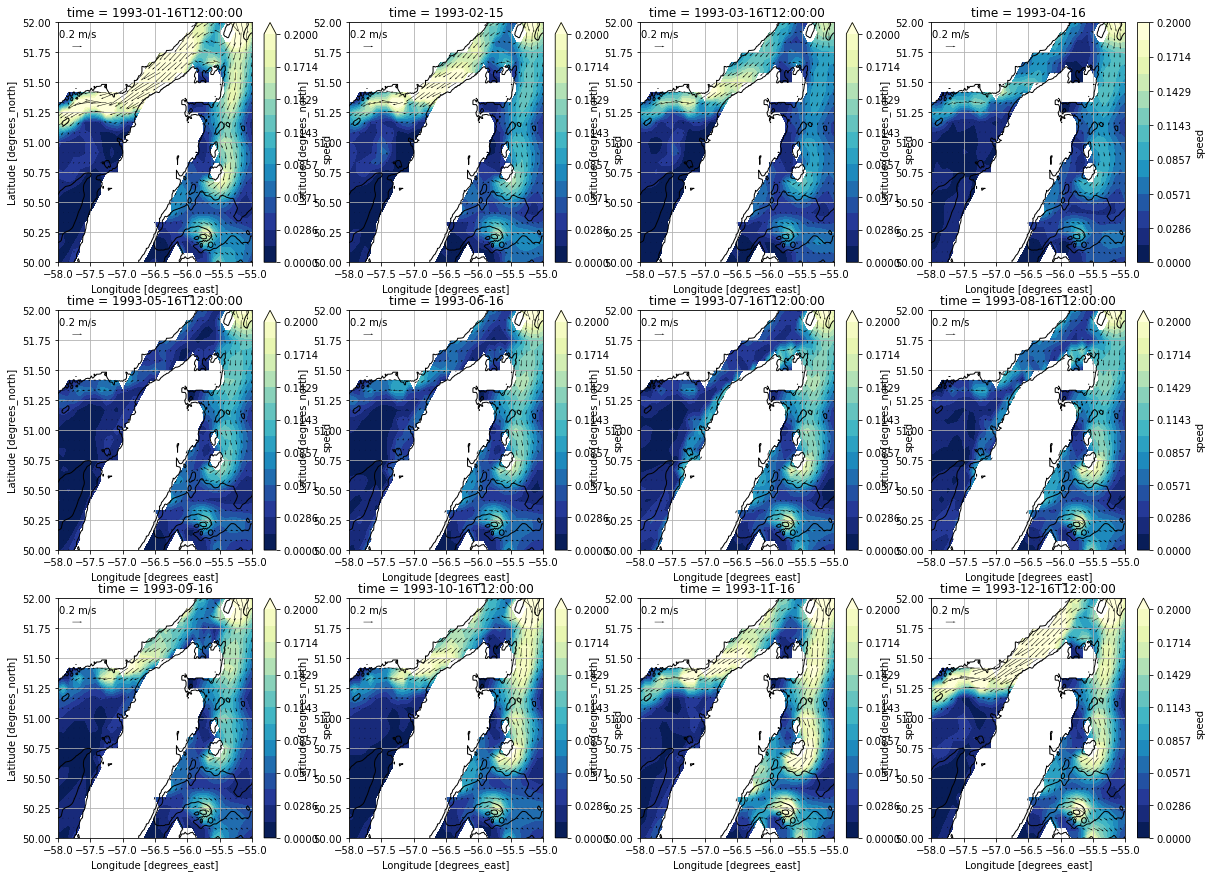

In [9]:

fig,axs = plt.subplots(3,4, figsize=(20,15))
for ax, t in zip(axs.flatten(), dnew.time.values):
    dt = dnew.sel(time=t)
    dt.speed.plot.contourf(x='longitude',y='latitude',levels=np.linspace(0,0.2,num=15),
                                        cmap='YlGnBu_r',ax=ax)
    q = ax.quiver(dt.longitude.values,dt.latitude.values, dt.udepav.values, dt.vdepav.values,
                  scale=4)
    ax.quiverkey(q, 0.1,0.9, 0.2, '0.2 m/s')
    plot_bathymetry(ax,esel)
    ax.grid()
    ax.set_xlim([lon_min,lon_max])
    ax.set_ylim([lat_min,lat_max])